In [1]:
import numpy as np
import pandas as pd

In [2]:
resume_data = pd.read_csv("Resume.csv")
resume_data

ID                                         Resume_str  \
0     16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1     22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2     33176873           HR DIRECTOR       Summary      Over 2...   
3     27018550           HR SPECIALIST       Summary    Dedica...   
4     17812897           HR MANAGER         Skill Highlights  ...   
...        ...                                                ...   
2479  99416532           RANK: SGT/E-5 NON- COMMISSIONED OFFIC...   
2480  24589765           GOVERNMENT RELATIONS, COMMUNICATIONS ...   
2481  31605080           GEEK SQUAD AGENT         Professional...   
2482  21190805           PROGRAM DIRECTOR / OFFICE MANAGER    ...   
2483  37473139           STOREKEEPER II       Professional Sum...   

                                            Resume_html  Category  
0     <div class="fontsize fontface vmargins hmargin...        HR  
1     <div class="fontsize fontface vmargins hmargin...        HR  
2     <div class="fontsize fontface vmargins hmargin...        HR  
3     <div class="fontsize fontface vmargins hmargin...        HR  
4     <div class="fontsize fontface vmargins hmargin...        HR  
...                                                 ...       ...  
2479  <div class="fontsize fontface vmargins hmargin...  AVIATION  
2480  <div class="fontsize fontface vmargins hmargin...  AVIATION  
2481  <div class="fontsize fontface vmargins hmargin...  AVIATION  
2482  <div class="fontsize fontface vmargins hmargin...  AVIATION  
2483  <div class="fontsize fontface vmargins hmargin...  AVIATION  

[2484 rows x 4 columns]

In [3]:
from PyPDF2 import PdfReader
def extract_text_from_pdf(file_path):
    reader = PdfReader(file_path)
    text = "".join(page.extract_text() for page in reader.pages)
    return text

In [4]:
from nltk import pos_tag, sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
import re
def preprocess_text(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z]', ' ', text)
    sentences = sent_tokenize(text)
    features = {'feature': ""}
    stop_words = set(stopwords.words("english"))
    for sent in sentences:
        if any(criteria in sent for criteria in ['skills', 'education']):
            words = word_tokenize(sent)
            words = [word for word in words if word not in stop_words]
            tagged_words = pos_tag(words)
            filtered_words = [word for word, tag in tagged_words if tag not in ['DT', 'IN', 'TO', 'PRP', 'WP']]
            features['feature'] += " ".join(filtered_words)
    return features

In [54]:
def process_resume_data(df):
    id = df['ID']
    category = df['Category']
    text = extract_text_from_pdf(f"data/{category}/{id}.pdf")
    features = preprocess_text(text)
    df['Feature'] = features['feature']
    return df

In [ ]:
    num_desc = 15
    resume_data = pd.read_csv("Resume.csv")
    resume_data = resume_data.drop(["Resume_html"], axis=1)
    resume_data = resume_data.apply(process_resume_data, axis=1)
    resume_data = resume_data.drop(columns=['Resume_str'])
    resume_data.to_csv("resume_data.csv", index=False)

In [29]:
    job_description = pd.read_csv("training_data.csv")
    job_description = job_description[["job_description", "position_title"]][:num_desc]
    job_description['Features'] = job_description['job_description'].apply(lambda x : preprocess_text(x)['feature'])

In [30]:
resume_data

ID                                         Resume_str  Category
0     16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...        HR
1     22323967           HR SPECIALIST, US HR OPERATIONS      ...        HR
2     33176873           HR DIRECTOR       Summary      Over 2...        HR
3     27018550           HR SPECIALIST       Summary    Dedica...        HR
4     17812897           HR MANAGER         Skill Highlights  ...        HR
...        ...                                                ...       ...
2479  99416532           RANK: SGT/E-5 NON- COMMISSIONED OFFIC...  AVIATION
2480  24589765           GOVERNMENT RELATIONS, COMMUNICATIONS ...  AVIATION
2481  31605080           GEEK SQUAD AGENT         Professional...  AVIATION
2482  21190805           PROGRAM DIRECTOR / OFFICE MANAGER    ...  AVIATION
2483  37473139           STOREKEEPER II       Professional Sum...  AVIATION

[2484 rows x 3 columns]

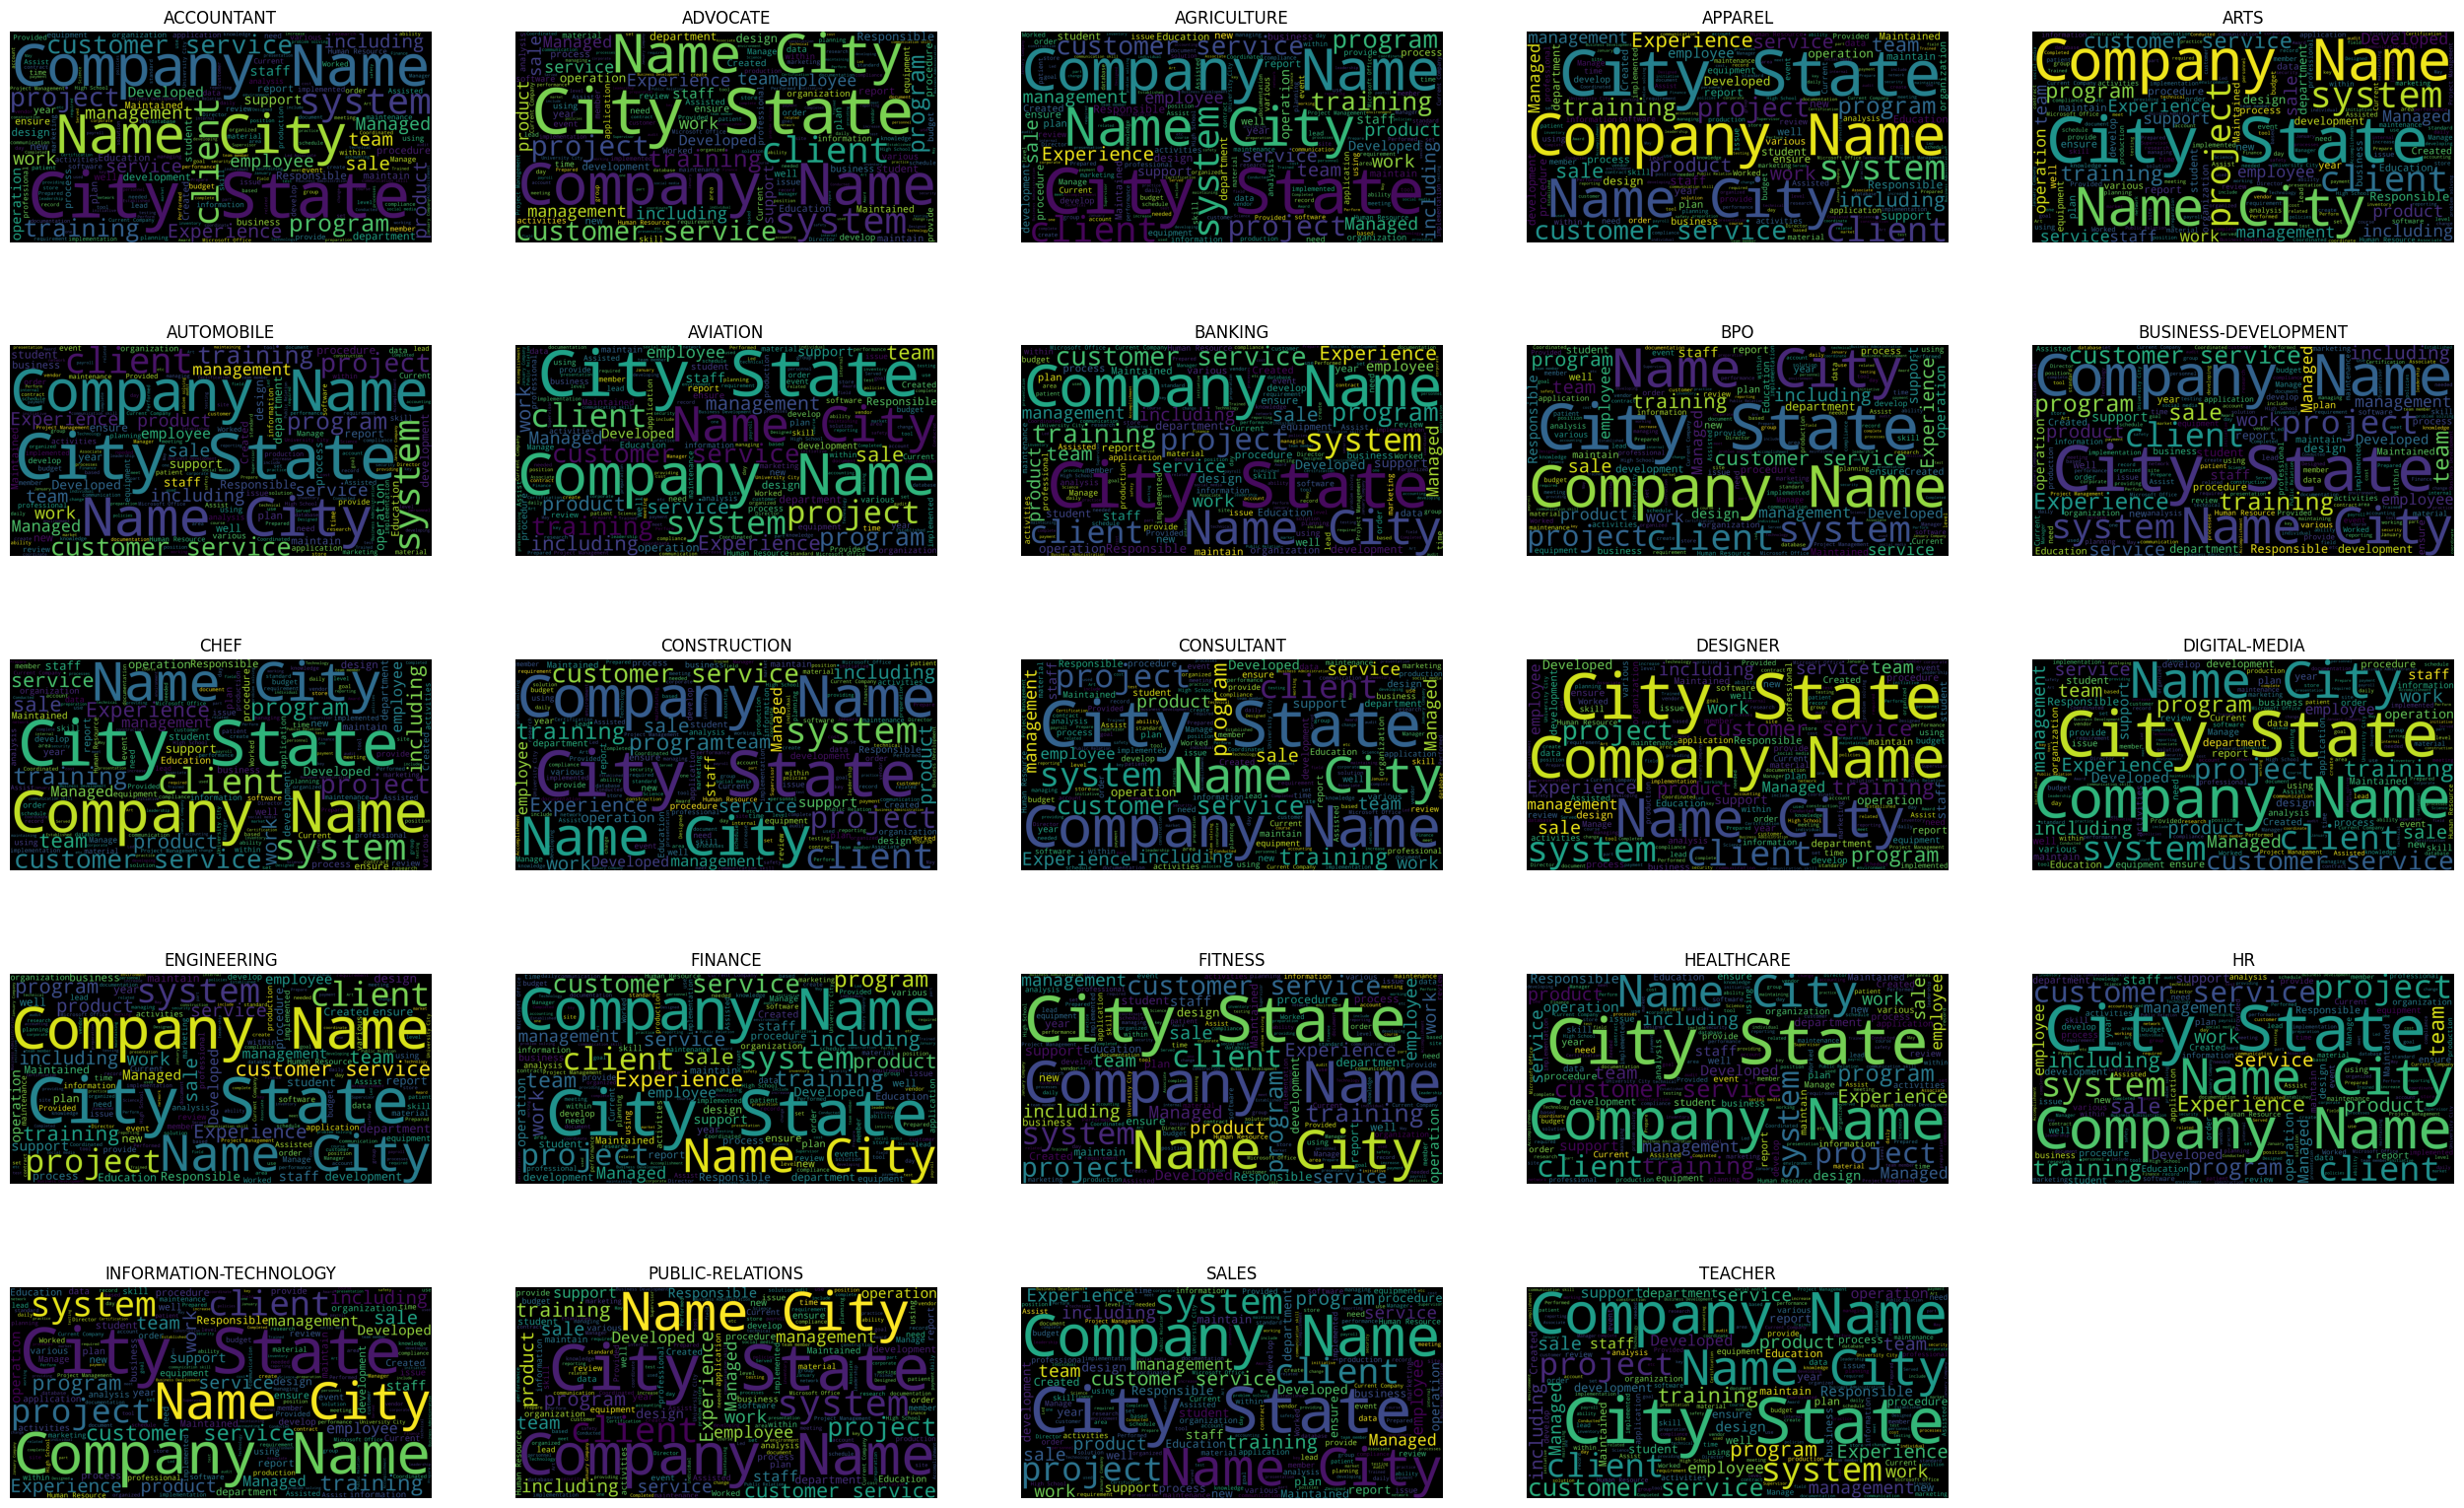

In [35]:
categories = np.sort(resume_data['Category'].unique())
categories
# create new df for corpus and category
df_categories = [resume_data[resume_data['Category'] == category].loc[:, ['Resume_str', 'Category']] for category in categories]
from wordcloud import WordCloud
def wordcloud(df):
    txt = ' '.join(txt for txt in resume_data['Resume_str'])
    wordcloud = WordCloud(
        height=2000,
        width=4000
    ).generate(txt)

    return wordcloud
import matplotlib.pyplot as plt
plt.figure(figsize=(32, 20))
for i, category in enumerate(categories):
    wc = wordcloud(df_categories[i])

    plt.subplot(5, 5, i + 1).set_title(category)
    plt.imshow(wc)
    plt.axis('off')
    plt.plot()

plt.show()
plt.close()

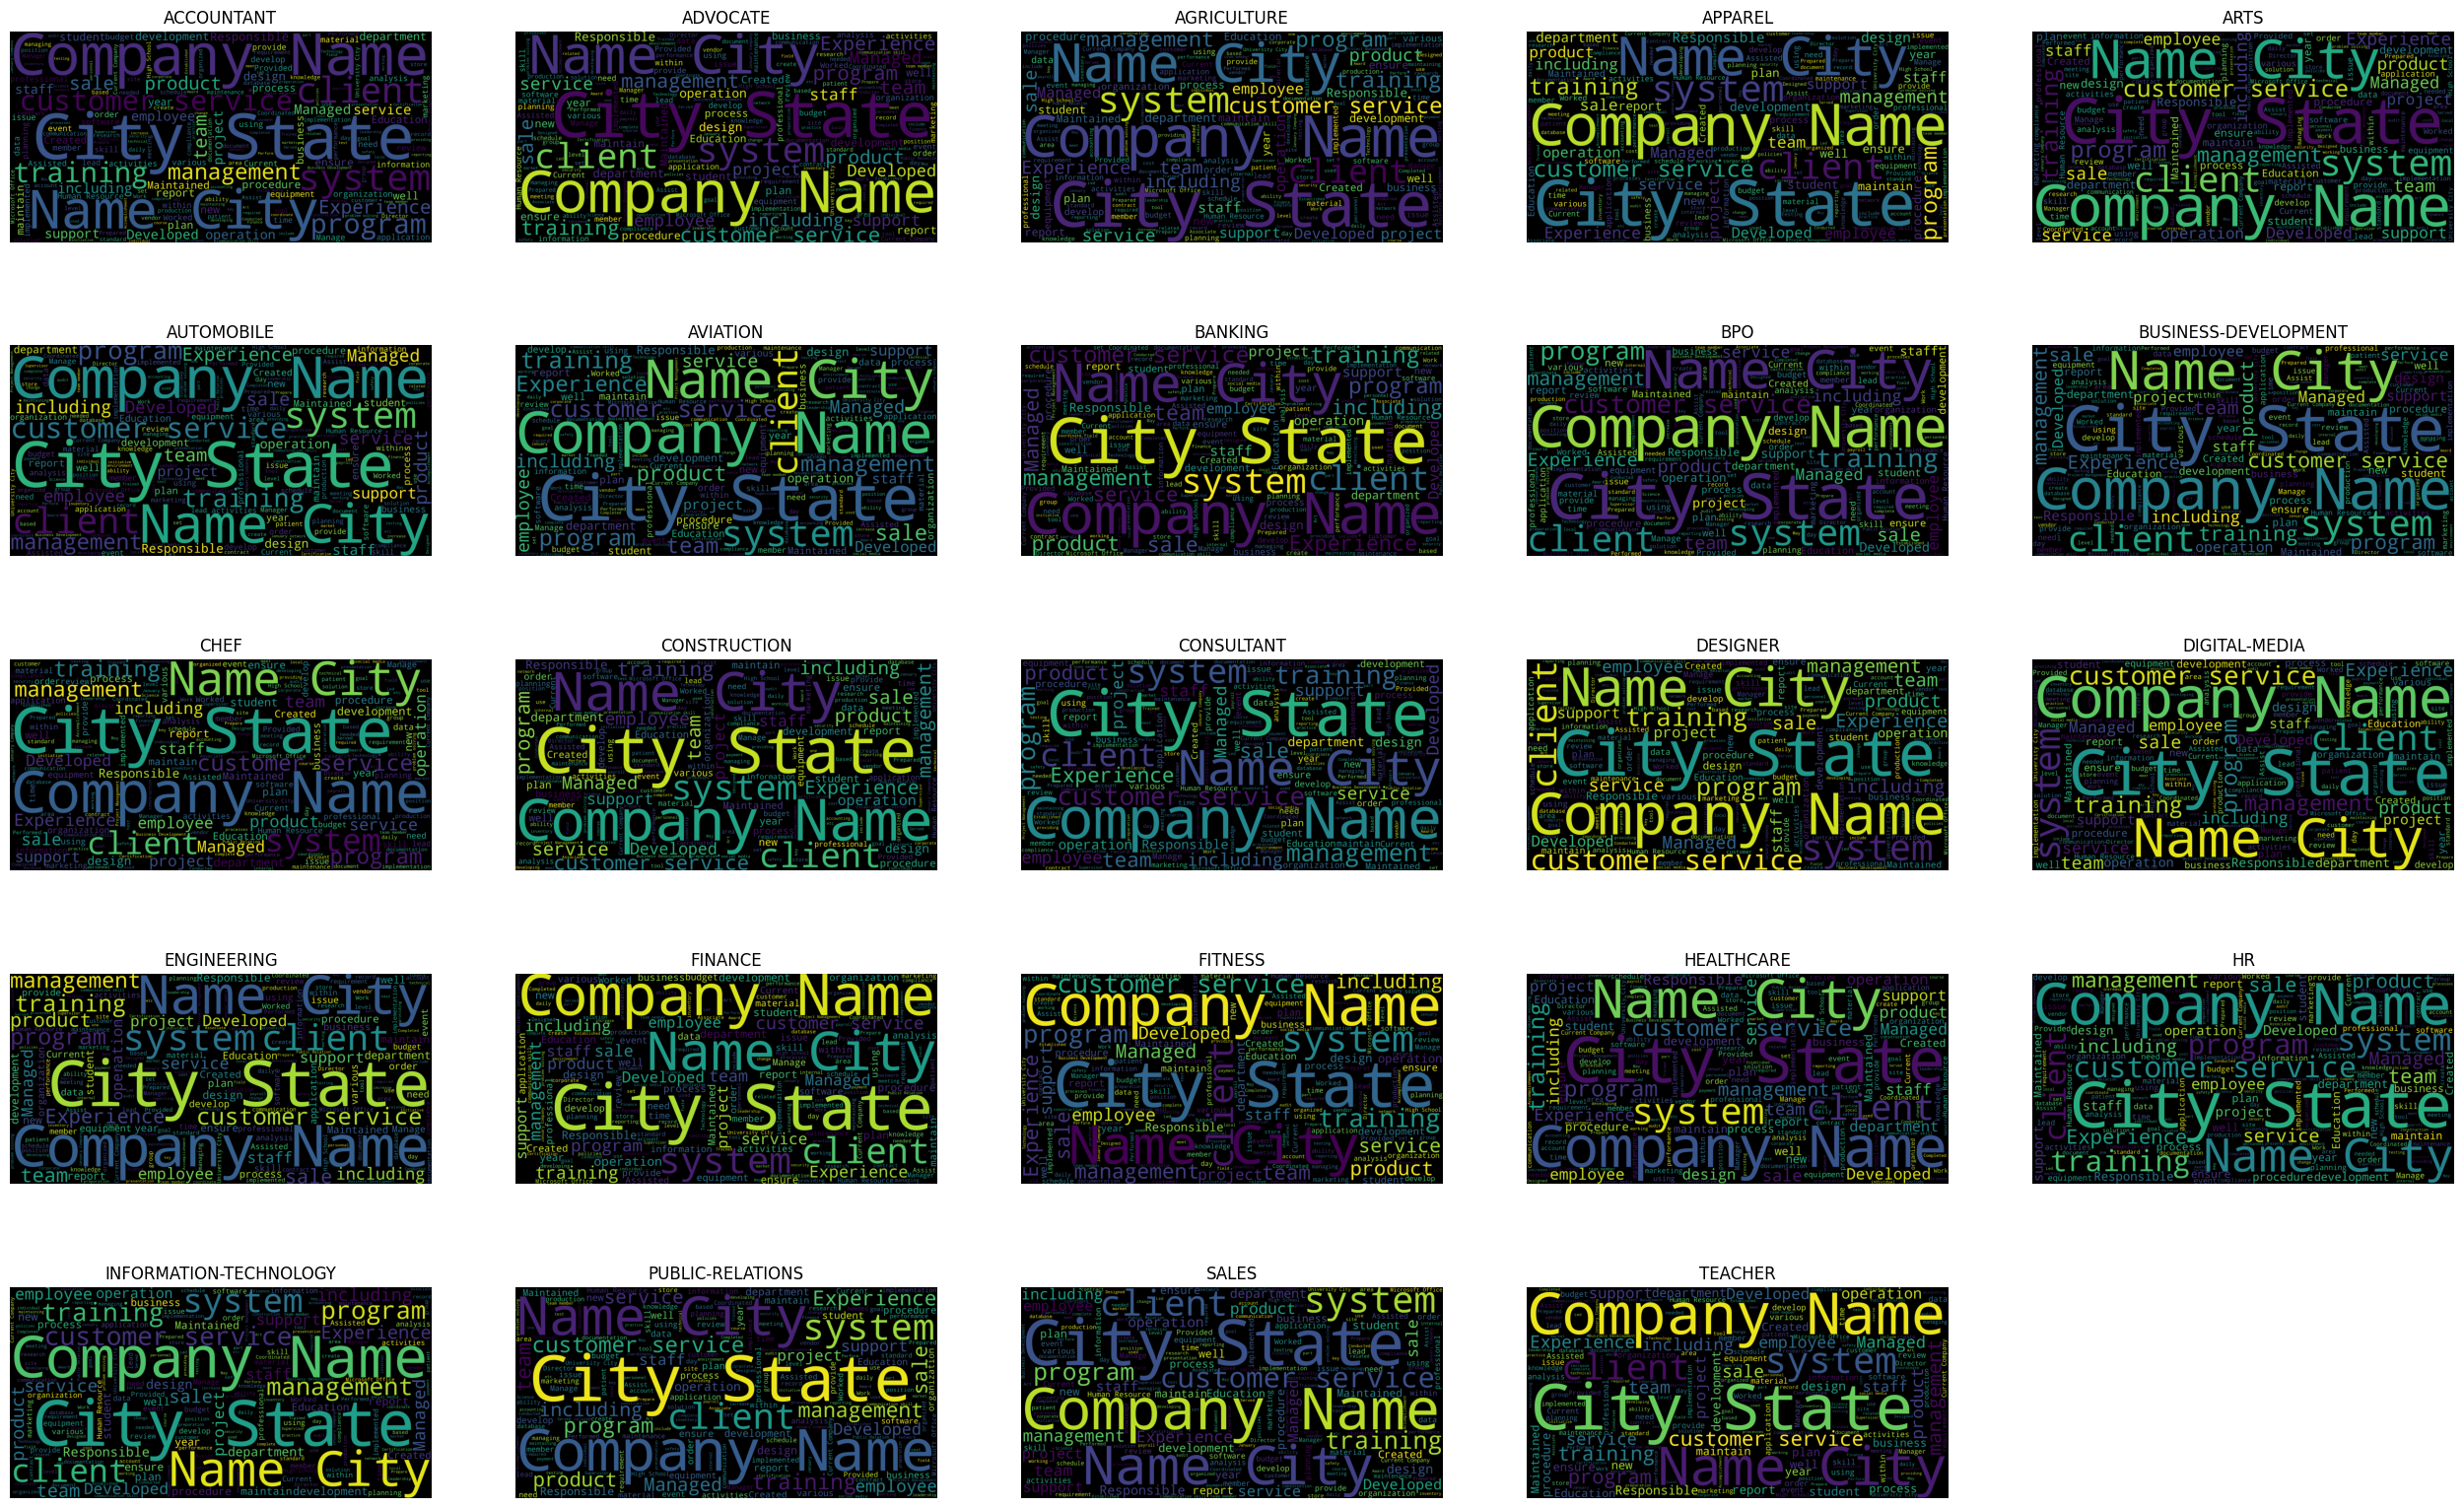

In [37]:
def remove_extra_word(text):
    
    extra_word=['company', 'name', 'citi', 'state', 'work', 'manag', 'project']
    words = text.split()
    filter_word = [word for word in words if word not in extra_word]
    
    filter_text = ' '.join(filter_word)
    
    return filter_text

resume_data['Resume_str']=resume_data['Resume_str'].apply(lambda x:remove_extra_word(x))
plt.figure(figsize=(32, 20))

for i, category in enumerate(categories):
    wc = wordcloud(df_categories[i])
    plt.subplot(5, 5, i + 1).set_title(category)
    plt.imshow(wc)
    plt.axis('off')
    plt.plot()

plt.show()
plt.close()

In [38]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()

resume_data['Category']=encoder.fit_transform(resume_data['Category'])
resume_data.head()

ID                                         Resume_str  Category
0  16852973  HR ADMINISTRATOR/MARKETING ASSOCIATE HR ADMINI...        19
1  22323967  HR SPECIALIST, US HR OPERATIONS Summary Versat...        19
2  33176873  HR DIRECTOR Summary Over 20 years experience i...        19
3  27018550  HR SPECIALIST Summary Dedicated, Driven, and D...        19
4  17812897  HR MANAGER Skill Highlights HR SKILLS HR Depar...        19

In [39]:
resume_data.Category.unique().shape

(24,)

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(resume_data['Resume_str'], resume_data['Category'], test_size=0.15, random_state=42, stratify=resume_data['Category'])

print("Train data size:", X_train.shape)
print("Validation data size:", X_test.shape)

Train data size: (2111,)
Validation data size: (373,)


In [42]:
job_description

job_description  \
0   minimum qualifications\nbachelors degree or eq...   
1   description\nas an asc you will be highly infl...   
2   its an amazing time to be joining netflix as w...   
3   description\n\nweb designers looking to expand...   
4   at trackfive weve got big goals were on a miss...   
5   designups is a nashville based design and inte...   
6   about the position\n\nthe web designer is resp...   
7   job description\n\nzander insurance group is o...   
8   tuff is a growth marketing team working with c...   
9   type of requisition regular\n\nclearance level...   
10  web developer\n\njob id \n\n positions \n\nloc...   
11  snapshot is looking for a back end developer t...   
12   we are seeking a senior ui designer who relis...   
13   design develop and test high quality software...   
14  if youre passionate about building a better fu...   

                               position_title  \
0                            Sales Specialist   
1                  Apple Solutions Consultant   
2   Licensing Coordinator - Consumer Products   
3                                Web Designer   
4                               Web Developer   
5                      Frontend Web Developer   
6                     Remote Website Designer   
7                                Web Designer   
8                                Web Designer   
9                            SR. Web Designer   
10                              Web Developer   
11                              Web Developer   
12                         Senior UI Designer   
13                    Wordpress Web Developer   
14                            UI Web Designer   

                                             Features  
0   minimum qualifications bachelors degree equiva...  
1   description asc highly influential growing min...  
2   amazing time joining netflix continue transfor...  
3   description web designers looking expand profe...  
4   trackfive weve got big goals mission revolutio...  
5   designups nashville based design interactive a...  
6   position web designer responsible providing de...  
7                                                      
8   tuff growth marketing team working clients dri...  
9   type requisition regular clearance level must ...  
10  web developer job id positions location ustnna...  
11  snapshot looking back end developer join organ...  
12  seeking senior ui designer relishes methodical...  
13  design develop test high quality software feat...  
14  youre passionate building better future indivi...

In [43]:
job_desc = job_description.drop(['job_description', 'position_title'], axis=1)
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(stop_words='english',max_features=800)
tfidf_train_vectors = tfidf.fit_transform(X_train)
tfidf_test_vectors =tfidf.transform(X_test)

tfidf_jobDesc_vectors = tfidf.fit_transform(job_desc['Features'])
tfidf_train_vectors

<2111x800 sparse matrix of type '<class 'numpy.float64'>'
	with 352769 stored elements in Compressed Sparse Row format>

In [44]:
tfidf_jobDesc_vectors_dense = tfidf_jobDesc_vectors.toarray()
tfidf_train_vectors_dense = tfidf_train_vectors.toarray()
tfidf_train_vectors_dense.shape, tfidf_jobDesc_vectors_dense.shape

((2111, 800), (15, 800))

In [45]:
tfidf_test_vectors

<373x800 sparse matrix of type '<class 'numpy.float64'>'
	with 64478 stored elements in Compressed Sparse Row format>

In [46]:
tfidf.get_feature_names_out()

array(['abilities', 'ability', 'able', 'access', 'account', 'accounts',
       'act', 'action', 'active', 'ada', 'adding', 'additional', 'adobe',
       'adobexd', 'ads', 'advance', 'advanced', 'advertising', 'advocate',
       'aesthetic', 'agency', 'amazing', 'andor', 'annual', 'api', 'apis',
       'apple', 'applicable', 'applicants', 'application', 'applications',
       'applied', 'apply', 'applying', 'apps', 'area', 'art', 'artist',
       'artists', 'assets', 'assigned', 'attention', 'audio',
       'authorized', 'available', 'bachelors', 'backend', 'backgrounds',
       'based', 'basic', 'believe', 'benefits', 'best', 'better',
       'beverage', 'big', 'blogs', 'bonus', 'bootstrap', 'brand',
       'brands', 'bring', 'bringing', 'broad', 'build', 'building',
       'business', 'businessability', 'businesses', 'businessexperience',
       'calendars', 'campaigns', 'canada', 'candidate', 'candidates',
       'capabilities', 'capable', 'capacity', 'career', 'catalog',
       'cat

In [47]:
from sklearn.metrics.pairwise import cosine_similarity
k = 5
result_df = pd.DataFrame(columns=['jobId', 'resumeId', 'similarity', 'domainResume', 'domainDesc'])
for i, job_desc_emb in enumerate(tfidf_jobDesc_vectors_dense):
    job_desc_id = i
    job_title = job_description['position_title'].iloc[i]

    similarities = cosine_similarity([job_desc_emb], tfidf_train_vectors )
    top_k_indices = np.argsort(similarities[0])[::-1][:k]
   
    for j in top_k_indices:
        resume_id = resume_data['ID'].iloc[j]
        work_domain = resume_data['Category'].iloc[j]
        similarity_score = similarities[0][j]
        
        result_df.loc[i+j] = [job_desc_id, resume_id, similarity_score, work_domain,job_title ]
        
result_df = result_df.sort_values(by='similarity', ascending=False)
result_df.head()

jobId  resumeId  similarity  domainResume  \
1732      2  39855211    0.381471            15   
1519      3  14413148    0.374823            16   
364       4  14958913    0.355897            23   
411       3  13583538    0.353604            23   
211       8  24583187    0.337468            13   

                                     domainDesc  
1732  Licensing Coordinator - Consumer Products  
1519                               Web Designer  
364                               Web Developer  
411                                Web Designer  
211                                Web Designer

In [48]:
result_group=result_df.groupby("jobId")
result_group

In [51]:
num_desc = 15
for i in range(num_desc):
    print()
    print("JobId CosineSimilarity DomainResume DomainDescription")
    print(result_group.get_group(i).values[0])
    print()


JobId CosineSimilarity DomainResume DomainDescription
[0 22706174 0.24652425389962407 14 'Sales Specialist']


JobId CosineSimilarity DomainResume DomainDescription
[1 12695799 0.2276547425951832 17 'Apple Solutions Consultant']


JobId CosineSimilarity DomainResume DomainDescription
[2 39855211 0.3814709253546329 15
 'Licensing Coordinator - Consumer Products']


JobId CosineSimilarity DomainResume DomainDescription
[3 14413148 0.3748225031320807 16 'Web Designer']


JobId CosineSimilarity DomainResume DomainDescription
[4 14958913 0.35589650851951316 23 'Web Developer']


JobId CosineSimilarity DomainResume DomainDescription
[5 20345168 0.25371001016813655 0 'Frontend Web Developer']


JobId CosineSimilarity DomainResume DomainDescription
[6 87968870 0.308900788071881 19 'Remote Website Designer']


JobId CosineSimilarity DomainResume DomainDescription
[7 16132195 0.0 18 'Web Designer']


JobId CosineSimilarity DomainResume DomainDescription
[8 24583187 0.33746838274995933 13 'Web D